# Predicting Arrest
# and Demistifying pre concieved assumptions

#### Predictive Analytics with the City of Dunwoody Police Department 

*What can we say about ourselves confidently?* <br/>

The popularity of data science reveals the power of statistics and scientific models to measure, predict, and guide an organization's ability to thrive.  <bra/>
This is fundamentally why we examine an organization's data. Discovery of trends may lead to actionable insight or change in policy.  Data Science also gives organizations situational awareness, client interaction with web presence, or mitigating risk for sustained planning. What is the organization in growth compared to others of similar measure? Are you ahead or behind? Do you do something well that others don't?  How do you think the organization is operating; how is it really operating? Data science gives Dunwoody the ability confidentially analyze trends to gain insights to shape who they are and where they want to go. Insights of crime can assist the police operations and create an even safer and efficient city. Dunwoody as an organization can be more prepared to respond to crime and take action based on trends and machine learning for predictive policing. 

In [2]:
import pandas as pd
import numpy as np

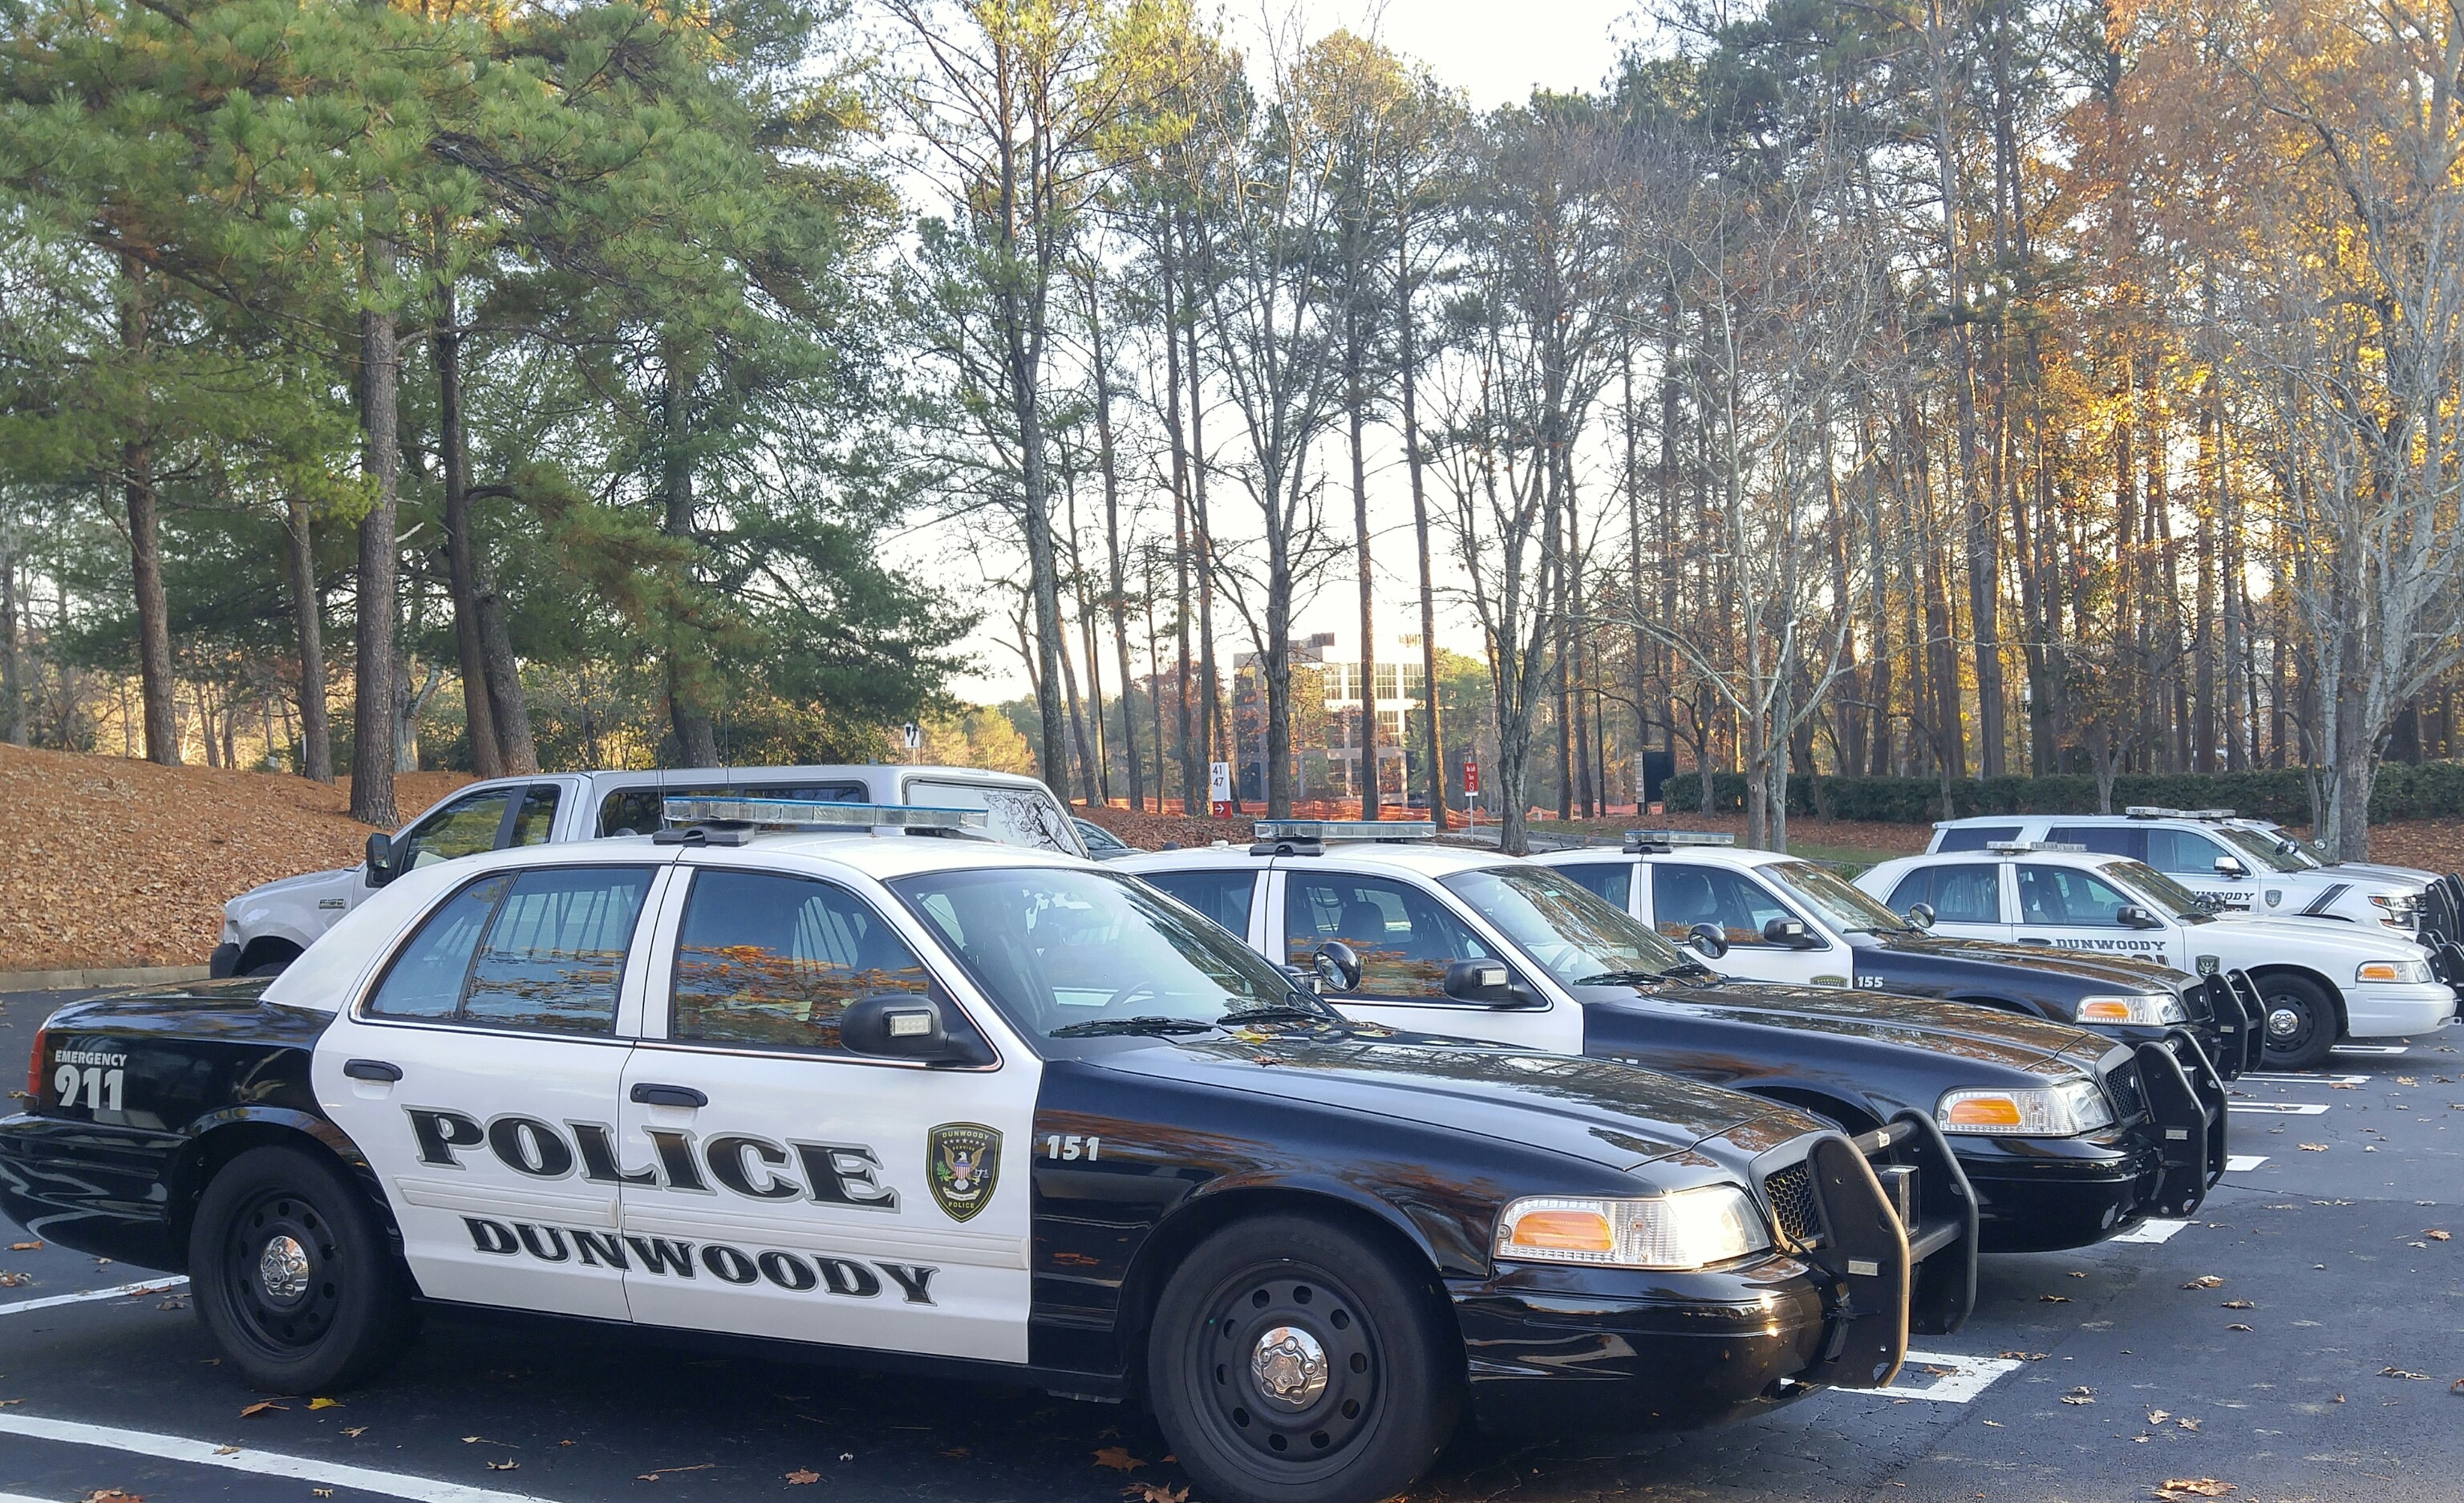

In [3]:
from IPython.display import Image
Image(filename='DPD.jpg')

In [21]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('Maps/GenReferenceMap_s.pdf', size = (1000, 800))

cheesy quick reference map of Dunwoody

### Materials
Broadly speaking the tools and equipment I will be using jupyter notebook as my workspace and exploring data in Python. Main python apis I will be working with are numpy, pandas, seaboarn, matplotlib, and sklearn. Pandas is for working in Data Frames (data tables). Matplotlib and Seaboarn are for data visualizations. Sklearn is for data anaysis/ machine learning algorithims.  I will also be using open source GIS software called QGIS to make an index grid over the area of study and to summarize events by index.<br/>
What do we have to work with here? A look at the data- <br/>
Dunwoody Police Department database has around 450 tables!! Many are empty, but still is quite confusing and is a whole lot of data. Data requires a good scrubb down. Will use pre-cleaned publically available data.<br/>

The timeframe of data we are looking at begins with the Police Departments inception in 2010 when the City of Dunwoody was formed up to the present day of this project - January 2017.

### Data Preprocessing

I have access to the Dunwoody Police Department SQL Database.  I have explored the tables in the database.  I exported tables from the SQL database using to an esri geodatabase then used a script/tool to convert to a csv table. The formatting was better preserved sending the data through this route rather then exporting straight to flat file from SQL Server, however . The size of the data when exporting the entire time frame became too large to store on github.  An Amazon Web Services S3 account was created to store the data in a bucket in AWS s3.  A detailed look at the tables in the database can be viewed in another under the DPD repo called Data.ipynb https://github.com/akell47/DPD/blob/master/Data.ipynb. (Must be a collaborator to view) To narrow it down and simplify the project I decided to focus on one primary table - the lwmain table which is the main incident table.  Data preprocessing of this table was explored in lwmain.ipynb https://github.com/akell47/DPD/blob/master/lwmain.ipynb.  Two major cleaning processes were applied to the data - dropping columns that contained null (or None, or 0) values and grouping up incidents into a more generalized category in a new column.  Both of these cleaning methods are super useful to carry on with future data. 

In [5]:
# dropping null(ish) columns 
# Can clean up the tables with this awesome code that strips the spaces
# If no string then return Null, if 0, None, or "None" return Null 
# otherwise will return the stripped of whitespace on the ends value
import pandas as pd
import numpy as np

def cleanse(df, amt):
    
    def cleanCells(c):
        if c == "None":
            return np.nan
        if c == None:
            return np.nan
        if c == 0:
            return np.nan
        if c == "NaN":
            return np.nan
        if type(c) != str:
            return c
        trimm = c.strip()
#         strips white space on either side of the cell - awesome
        c = trimm if trimm else np.nan
#         ternary expression C is the trimmed value 
# if it is not then make it null basically 
#   C the cell value is returned
        return c

#   map these filtered columns back to the dataframe with:
    df[df.columns] = df.apply(lambda y: map(cleanCells,y))
    
#   get a count of null values per each column with:  
    nullCount = df.isnull().sum()

# make a Series for column and values:
    columns = nullCount.keys().tolist()
    nullVals = nullCount.values.tolist()
 
# make a dicionary with zip 
    lookup = zip(columns, nullVals)
    
#     pctNull = nullCount/float(len(columns))
# from null value dictionary filter pairs that have a given amount
    pairsToDrop = filter(lambda (column, nullVals): nullVals > amt, lookup)
#  give column names that meet the threshold   
    columnsToDrop = map(lambda (column, nullVals): column, pairsToDrop)
#  drop em!   
    df.drop(columnsToDrop, axis = 1, inplace = True)
    
    return df

 

#### Cleaned up Data Available Online already
Turns out that Dunwoody Police Department main incident table (lwmain) is already available online through a sweet data vendor called socrata https://socrata.com/.  Due to the limited amount of time available to continue with data preprocessing, I wil use the pre-cleaned data as my dataset.  Sandy Springs Police Department Data is also available in the same format. I will merge these two tables together then select the time frame from 2010 to 2016 to have 7 full years of geospatially contigous incident data. The reason for the time has to do with the availability of the data.  <br/> 
The public data has much less columns. The lat and long is much more complete from the DPD socracta data. I can use this base data and join it to the lwmain table from the Database and/or the table that corresponds with the case_id table. 
 * Sandy Springs https://moto.data.socrata.com/dataset/Dunwoody-Police/nn2g-zfks
 * Dunwoody https://moto.data.socrata.com/dataset/Dunwoody-Police/nn2g-zfks
 


In [3]:
DUN = pd.read_csv('Data/Dunwoody_Police.csv')
DUN.tail(3)

C:\Users\Amber\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
37472,771472538,56559,09/01/2016 10:47:00 AM,- FORGERY- OF CHECK,FORGERY- OF CHECK,NaN,100 Block PERIMETER CTR W,NaN,DUNWOODY,GA,30346,NaN,33.926917,-84.342415,09/09/2016 08:39:10 AM,09/15/2016 10:52:02 PM,POINT (-84.3424149 33.9269172),10,Thursday,Theft
37473,772135788,56755,09/14/2016 04:40:00 PM,- LOST & FOUND PROPERTY,LOST & FOUND PROPERTY,NaN,200 Block & CHAMBLEE DUNWOODY RD,NaN,DUNWOODY,GA,30338,NaN,33.959867,-84.344938,09/15/2016 12:24:23 PM,09/28/2016 08:22:22 PM,POINT (-84.3449383 33.9598673),16,Wednesday,Property Crime
37474,771472555,56575,09/06/2016 04:18:00 PM,- LARCENY-SHOPLIFTING,LARCENY-SHOPLIFTING,NaN,4400 Block ASHFORD DUNWOODY RD,NaN,DUNWOODY,GA,30346,NaN,33.923471,-84.341313,09/09/2016 08:39:10 AM,09/27/2016 02:22:11 AM,POINT (-84.3413134 33.9234708),16,Tuesday,Theft


In [6]:
cleanse (DUN, 5000)
DUN.tail(3)
#boom, dropped null values!
# (not sorted by date)

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,address_1,city,state,zip,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
37472,771472538,56559,09/01/2016 10:47:00 AM,- FORGERY- OF CHECK,FORGERY- OF CHECK,100 Block PERIMETER CTR W,DUNWOODY,GA,30346,33.926917,-84.342415,09/09/2016 08:39:10 AM,09/15/2016 10:52:02 PM,POINT (-84.3424149 33.9269172),10.0,Thursday,Theft
37473,772135788,56755,09/14/2016 04:40:00 PM,- LOST & FOUND PROPERTY,LOST & FOUND PROPERTY,200 Block & CHAMBLEE DUNWOODY RD,DUNWOODY,GA,30338,33.959867,-84.344938,09/15/2016 12:24:23 PM,09/28/2016 08:22:22 PM,POINT (-84.3449383 33.9598673),16.0,Wednesday,Property Crime
37474,771472555,56575,09/06/2016 04:18:00 PM,- LARCENY-SHOPLIFTING,LARCENY-SHOPLIFTING,4400 Block ASHFORD DUNWOODY RD,DUNWOODY,GA,30346,33.923471,-84.341313,09/09/2016 08:39:10 AM,09/27/2016 02:22:11 AM,POINT (-84.3413134 33.9234708),16.0,Tuesday,Theft


#### Metadata 

Some of the parent_type I do not like how it is grouped. For example `Vehicle Impoundment` and `DUI` both are classified as `VEHICLE`. 
Will re-categorize some values


In [7]:
DUN.shape

(37475, 17)

In [8]:
import pandas as pd
Metadata = pd.read_csv('Data/DataDictionary.csv')
Metadata
# DATA DICTIONARY

,Column Name,Description,Type,Data Type
0,incident_id,Unique ID can join with lwmain table from the ...,Number,Unique ID
1,case_number,NaN,Plain Text,Unique ID
2,incident_datetime,Date of incident,Date & Time,Continuous
3,incident_type_primary,Grouped Category,Plain Text,Category
4,incident_description,Original Category,Plain Text,Category
5,address_1,Address,Plain Text,Location
6,city,City,Plain Text,Location
7,latitude,Latitude in Decimal Degrees (33.xxx),Number,Location
8,longitude,Longitude in Decimal Degrees (-84.xxx),Number,Location
9,hour_of_day,hour from 0 to 24 - number,Number,Category


In [9]:
weather2010 = pd.read_csv('Data/Weather2010.csv')
weather2010.head()
# weather by the day from weather underground
# will join by by incident_datetime or hour_of_day (hopefully) - mostly interested in Events column
# there is also a weather condition column in the lwmain table from the database - join and "fill -in" the weather condition data


,EST,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees
0,2010-1-1,44,37,28,42,30,17,93,70,43,...,10,10,6,21,12,32.0,0.0,4,NaN,315
1,2010-1-2,32,26,21,17,12,8,72,55,42,...,10,10,10,20,14,25.0,0.0,0,NaN,315
2,2010-1-3,32,24,17,10,6,-3,74,50,28,...,10,10,10,16,11,24.0,0.0,0,NaN,310
3,2010-1-4,30,24,17,13,10,6,71,59,45,...,10,10,10,18,12,26.0,0.0,1,NaN,309
4,2010-1-5,32,24,17,12,9,6,74,54,38,...,10,10,10,16,12,24.0,0.0,0,NaN,301


### Hypothesis and Research Question

Is there a trend in crimes and frequence across time and location?
* $h_0^a$ There is not a trend in types and frequency of crimes across days of the week
* $h_1^a$ There is a trend in the types and frequency of crimes across days of the week <br/><br/>
* $h_0^b$ There is not a trend in types and frequency of crimes across months of the year
* $h_1^b$ There is a trend in the types and frequency of crimes across months of the year <br/><br/>
* $h_0^c$ There is not a trend in types and frequency of crimes across hours in the day
* $h_1^c$ There is a trend in the types and frequency of crimes across hours in the day <br/><br/>
* $h_1^d$ There is not a trend in types and frequency of crimes across the city (by index grid)
* $h_1^d$ There is a trend in the types and frequency of crimes across the city (by index grid)<br/> <br/>

Also for weather conditions/ events, primary zoning type, and average income.


### Data Exploration and Visualization

Graphing the data presents a plesant way to validate the data which leads to assumptions. Graphical representations and visualizations of data  present an intuative and inviting way to explore and validate assumptions. It is easier and a much more pleasant experience to read from a picture than a sheet of numbers. <br/>
<br/>
**Summarize and plot**
* bar frequency of crime time
* - most top occuring
* - by day of the week
* - by month
*  map incidentes *spatially visualize*



### Predicion Method
Will use machine learning random forest with the time categories and index categories to predict crime <br/>
I will also use weather conditions as well hopefully. <br/>
Predictors - Time, index location, primary zoning, average income to predict crime type.

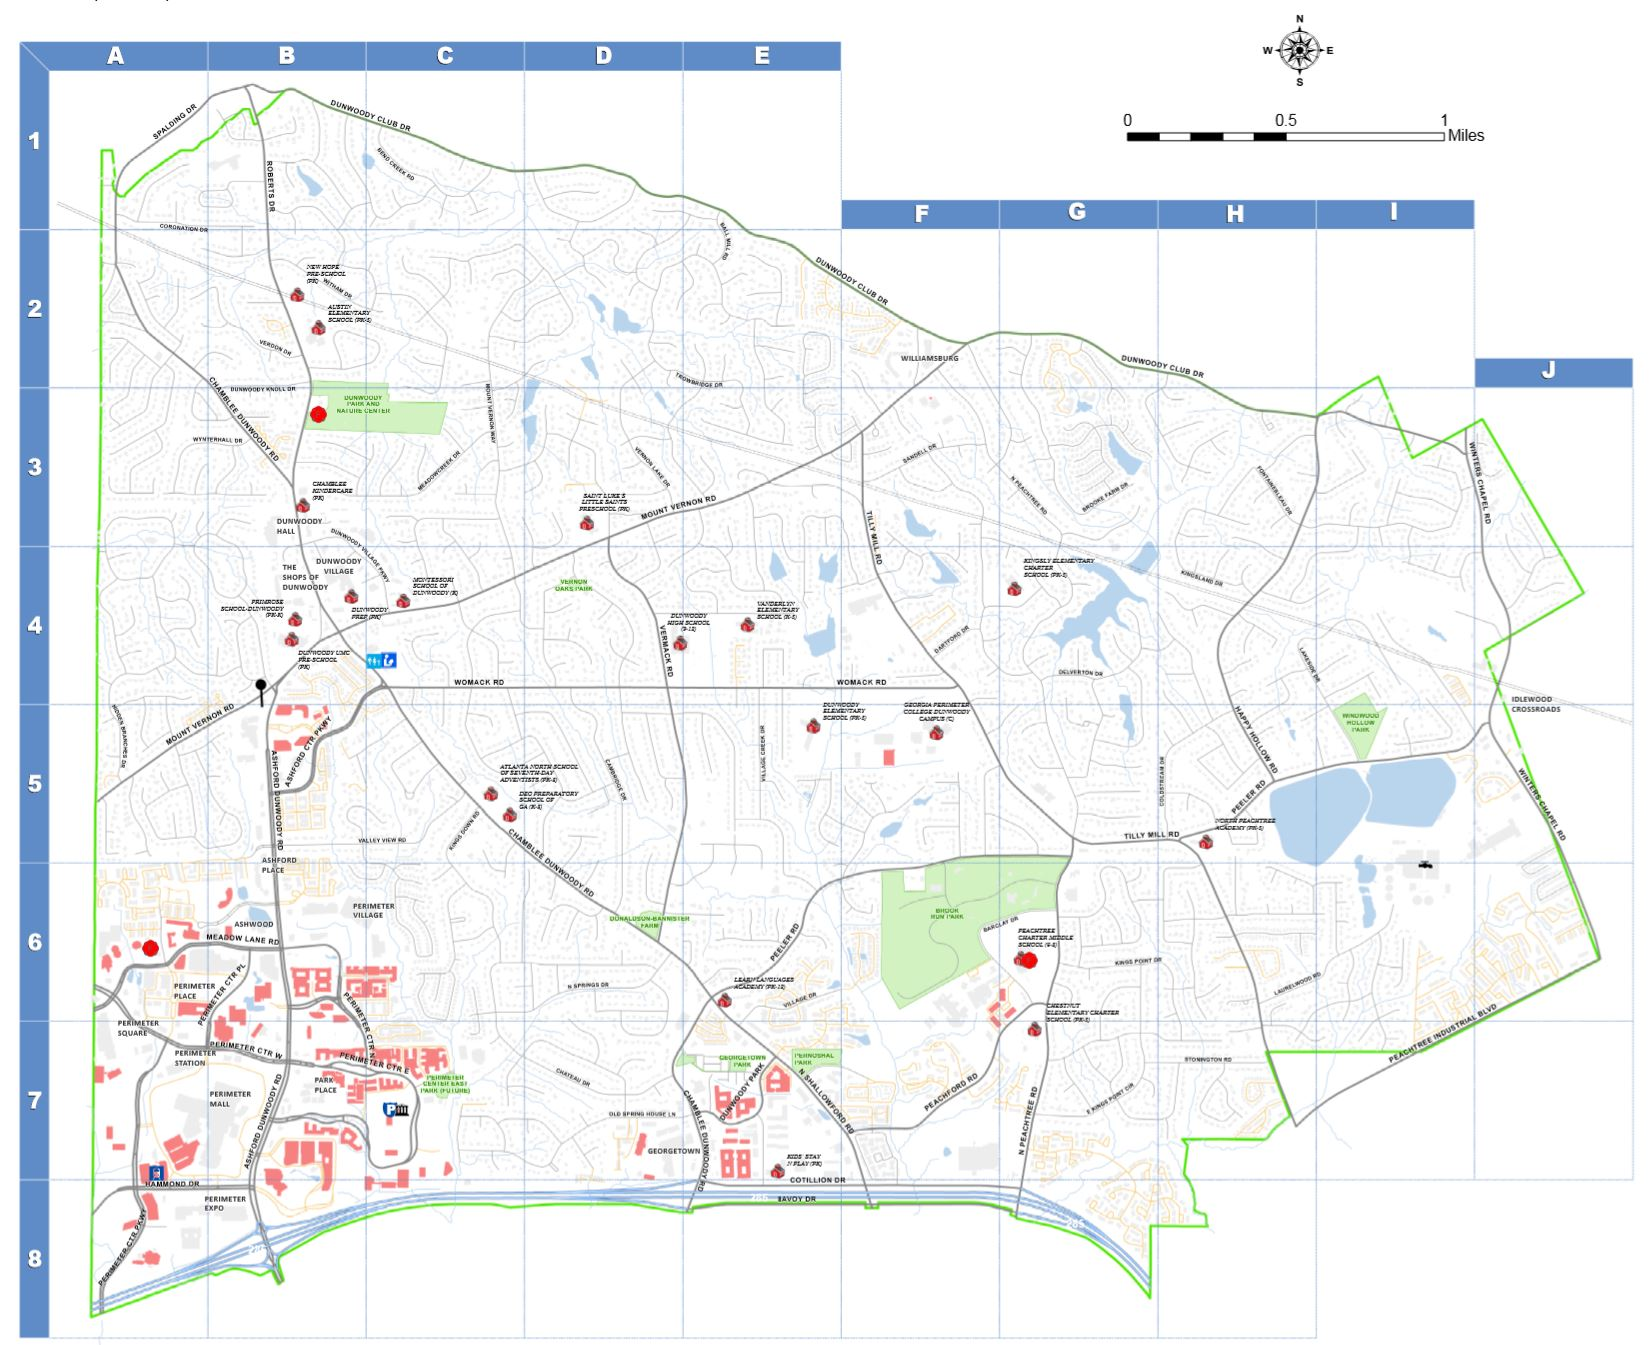

In [18]:
from IPython.display import Image
Image("Maps/IndexMapSample.JPG")
# Example of index grid

### Further Research Questions

When I join the PD data from the source with other tables in the databae can ask and explore more like:
* Do females arrest more females than men?
* Does the type of car you drive have a correlation to traffic incidences? 
* Is there a correlation between incidences and charges?
* Is there enough data to draw conclusions?
* Do more incindences of a certain type happen at clustered times or places?
* Is there a correlation with race of officers with race of people indidences?
* Compare crime data pre/post formation of a city referendom



Officers | Incidences | Demographics | Factors | Charges | Location

### Corresponding Research

In [15]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('Maps/November2016MonthlyReport.pdf', size = (800, 1000))

In [16]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

PDF('Maps/Speeders_Address_2016.pdf', size = (800, 1000))

http://desktop.arcgis.com/en/arcmap/10.3/manage-data/using-sql-with-gdbs/guidelines-to-choose-spatial-index-grid-size.htm <br/>
http://gisgeography.com/spatial-regression-models-arcgis/ <br/>
http://sedac.ciesin.columbia.edu/data/collection/usgrid/methods <br/>